In [1]:
%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from sklearn.decomposition import NMF, LatentDirichletAllocation

Load the entire features dataframe

In [64]:
religion_and_more_df.columns

MultiIndex(levels=[['2016_gdp_capita', 'POP', 'area', 'gov_type_num', 'name', 'religion'], ['', 'Animist religions', 'Baha'i', 'Buddhism', 'Christianism', 'Confucianism', 'Hindu', 'Islam', 'Jain', 'Judaism', 'Non-religious', 'Other religions', 'Shinto', 'Sikh', 'Syncretic religions', 'Taoism', 'Zoroastrian']],
           labels=[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 0, 3], [4, 9, 7, 3, 16, 6, 13, 12, 2, 15, 8, 5, 14, 1, 10, 11, 0, 0, 0]])

In [107]:
data = pickle.load(open('../DataEnriching/data.pickle','rb'))
data = data.reset_index()
data = data.set_index("ISO2")

# Keep only relevant fields 
data = data[['ISO2','POP', 'area', 'gdp', 'gdp_capita', 'pop_pov']]

lang_feature_df = pd.read_pickle('../LinkingLanguages/stand_country_dist_languages.pkl')
fligh_routes_df = pd.read_pickle('../GeoMetrics/flight_routes_std.pickle')
hop_distance_df = pd.read_pickle('../GeoMetrics/hop_distance_std.pickle')
neighbor_influence_df = pd.read_pickle('../GeoMetrics/neighbor_influence.pickle')
dist_feature_df = pd.read_pickle('../GeoMetrics/real_distance_std.pickle')
religion_and_more_df = pd.read_pickle('../DataEnriching/Pickles for Milestone 3/6_feature_df.pickle')

# Load the number of internet users
internet_users = pickle.load(open('internet_users.pickle','rb'))
internet_users.set_index("ISO2", inplace = True)
internet_users.replace("unknown", np.nan, inplace = True)
internet_users["Internet users"] = internet_users["Internet users"].astype(np.float)
med = np.median([x for x in internet_users["Internet users"].tolist() if not np.isnan(x)])
internet_users = internet_users["Internet users"].apply(lambda x: x if not(np.isnan(x)) else med)

# drop the name column : 
religion_and_more_df.drop(['name','POP'],axis=1,inplace=True)

#carefull the number of coutries is not the same in every pickle.
features_df = pd.concat([lang_feature_df,
           fligh_routes_df,
           hop_distance_df,
           neighbor_influence_df,
          dist_feature_df, data],axis=1)
#features_df.sort_index(axis=1,inplace=True)

features_df.loc[:,("Internet users")] = internet_users
features_df.loc[:,("Normalized internet users")] = med

for country in tqdm(features_df.index):
    users = features_df.loc[country,:]["Internet users"][0]
    pop = features_df.loc[country, :]["POP"][0]
    val = min(users, pop)/pop
    med_val =  min(med, pop)/pop
    #print(features_df.loc[country,"Normalized internet users"])
    
    if  (users!= -1) and (not(np.isnan(users))) and (not(np.isnan(pop))):
        if not np.isnan(val):
            features_df.loc[country,("Normalized internet users")] = val 
        else :
            features_df.loc[country,("Normalized internet users")]  = med_val
    else :
        features_df.loc[country,("Normalized internet users")]  = med_val

features_df.head()

/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/ipykernel/__main__.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
100%|██████████| 248/248 [00:01<00:00, 195.48it/s]


language_dist                                                       \
              AW    AF    AO    AI    AX    AL    AD    AE    AR   AM   
AD           4.0  16.0   4.0  19.0   3.0   3.0   0.0   5.0   3.0  3.0   
AE           5.0  10.0   5.0   4.0   4.0   4.0   5.0   0.0   4.0  4.0   
AF          17.5   0.0  20.0  15.0  13.0   7.0  16.0  10.0  18.0  9.5   
AG          13.0  15.0   3.0   0.0   3.0  10.0  19.0   4.0   3.0  7.5   
AI          13.0  15.0   3.0   0.0   3.0  10.0  19.0   4.0   3.0  7.5   

              ...            real_distance                             POP  \
              ...                       ZA        ZM        ZW               
AD            ...                -0.219753 -0.444163 -0.350166     85660.0   
AE            ...                -0.512312 -0.826798 -0.736734   5927482.0   
AF            ...                -0.232790 -0.543455 -0.457938  33332025.0   
AG            ...                 0.246926  0.243952  0.280601     93581.0   
AI            ...                 0.283821  0.279092  0.316367     16752.0   

        area           gdp gdp_capita pop_pov Internet users  \
                                                               
AD     468.0  4.800000e+09    37200.0   0.143           83.0   
AE   83600.0  3.750000e+11    67700.0   0.195      5274000.0   
AF  652230.0  1.840000e+10     2000.0   0.358      2690000.0   
AG     442.0  1.303000e+09    24100.0     NaN           60.0   
AI      91.0  1.754000e+08    12200.0   0.230           12.0   

   Normalized internet users  
                              
AD                  0.000969  
AE                  0.889754  
AF                  0.080703  
AG                  0.000641  
AI                  0.000716  

[5 rows x 1243 columns]

Functions used to process a given event

In [108]:
print([x for x in features_df.loc[:,("Internet users")] if x<0])

[]


In [111]:
def load_tweets(event, country_code):
    plt.figure(figsize = (15,10))
    # Loading the Number of tweets of the event in turkey per country
    summary_tweets = pickle.load(open('../../../Project Data/Tweets/{}/Geocoded/summary.pickle'.format(event), 'rb'))
    #plot = sns.barplot(summary_tweets.index,summary_tweets.text)
    return summary_tweets


def event_specific_features(country_code, summary_tweets):
    country_features_df = pd.concat([lang_feature_df.loc[:,("language_dist",country_code)],
                           fligh_routes_df.loc[:,("flight_routes",country_code)],
                           hop_distance_df.loc[:,("hop_distance",country_code)],
                           neighbor_influence_df.loc[:,("neighbor_influence",country_code)],
                           dist_feature_df.loc[:,("real_distance",country_code)], 
                           summary_tweets.loc[:,"text"],
                           data.loc[:,["area", "2016_gdp_capita", "gov_type_num", "POP", "2016_gdp_total"]],
                           features_df.loc[:,("Normalized internet users")],
                           features_df.loc[:,("Internet users")]],axis=1)
    #features_df.sort_index(axis=1,inplace=True)

    #print(list(country_features_df.columns))
    country_features_df.head(29)
    country_features_df.columns = ["language_dist", "flight_routes", "hop_distance", "neighbor_influence", \
                                   "real_distance", 'text', "POP", "area", 'norm_internet_users', \
                                   'Internet users']
    
    country_features_df.flight_routes = country_features_df.flight_routes.astype(np.float)
    country_features_df.neighbor_influence = country_features_df.neighbor_influence.astype(np.float)
    
    country_features_df["Normalized Tweets"] = country_features_df["text"] / country_features_df['Internet users']


    country_features_df.drop([country_code], inplace = True)
    return country_features_df

def plot_correlations_with_regression(country_features_df):
    fig = plt.figure(figsize = (15,20))

    y_all = country_features_df.loc[:,'Normalized Tweets'].tolist()

    for idx, column in enumerate(country_features_df.columns):
        ax = plt.subplot(len(country_features_df.columns)//3+1, 3, idx+1)
        x_all = country_features_df.loc[:,column].tolist()
        x = list()
        y = list()

        for i in range(len(x_all)):
            if (not np.isinf(x_all[i])) and (not np.isnan(x_all[i])):
                x.append(x_all[i])
                y.append(y_all[i])

        ax.plot(x, y, 'o', label='original data')
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        #print("{} regression, r^2 {:.3f}".format(column, r_value**2))
        ax.plot(np.array(x), intercept + slope*np.array(x), '--r', label='fitted line')
        ax.legend()
        ax.set_xlabel(column)
        ax.set_ylabel("Normalized number of tweets")
        plt.title("{} : r^2 {:.3f}".format(column, r_value**2) )
    fig.tight_layout()
        
        

def analyse_event(event_name, country_code):
    summary_tweets = load_tweets(event_name, country_code)
    country_features_df = event_specific_features(country_code,summary_tweets)
    #print(country_features_df.corr())
    sns.heatmap(abs(country_features_df.corr("spearman")[["text", "Normalized Tweets"]]),annot=True)
    plot_correlations_with_regression(country_features_df)

Load the tweets for an event

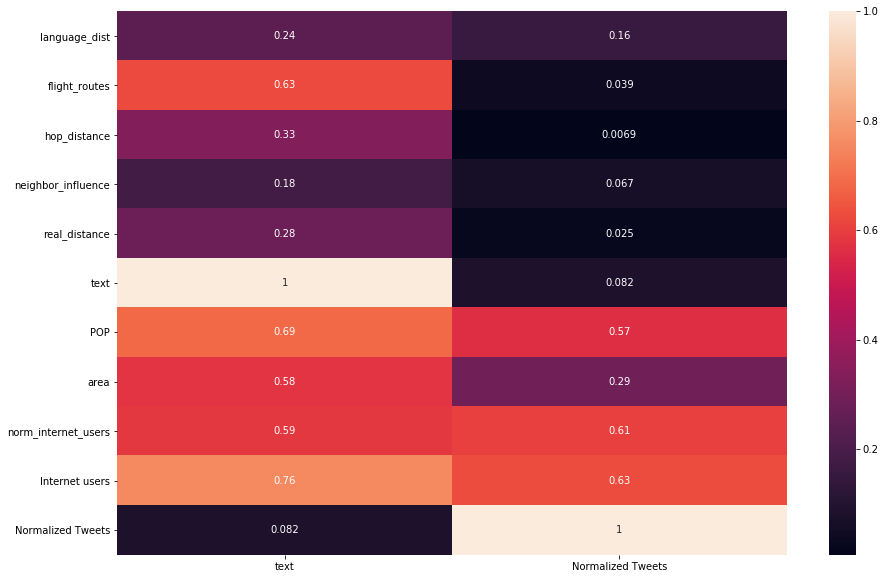

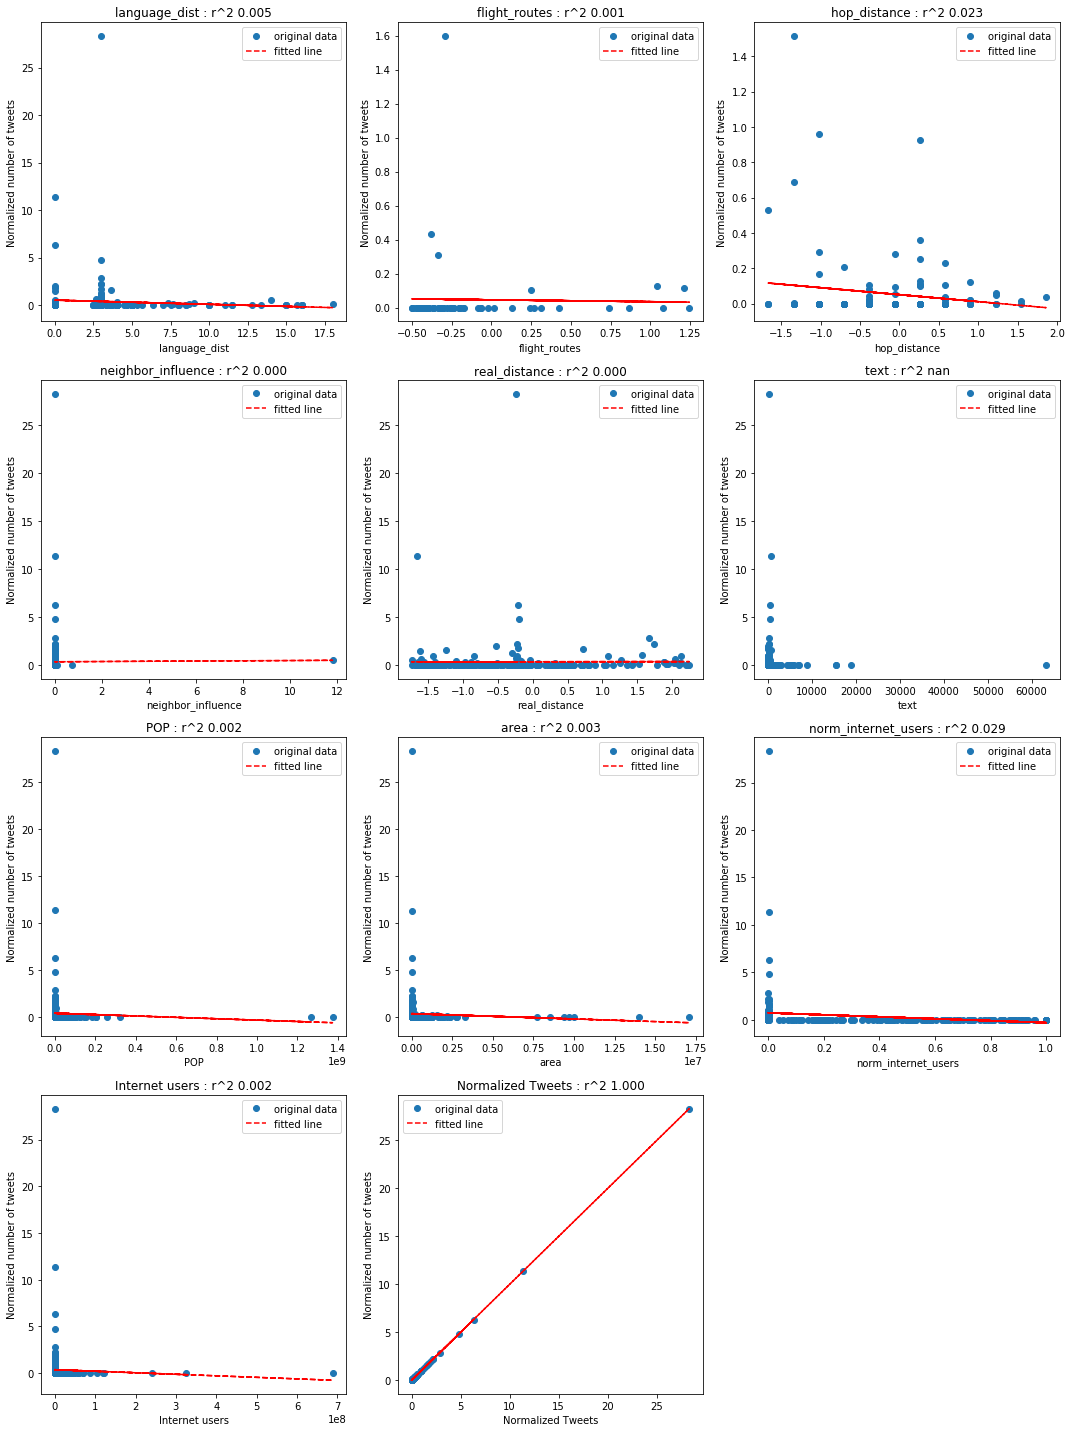

In [112]:
analyse_event("Bruxelles", "BE")

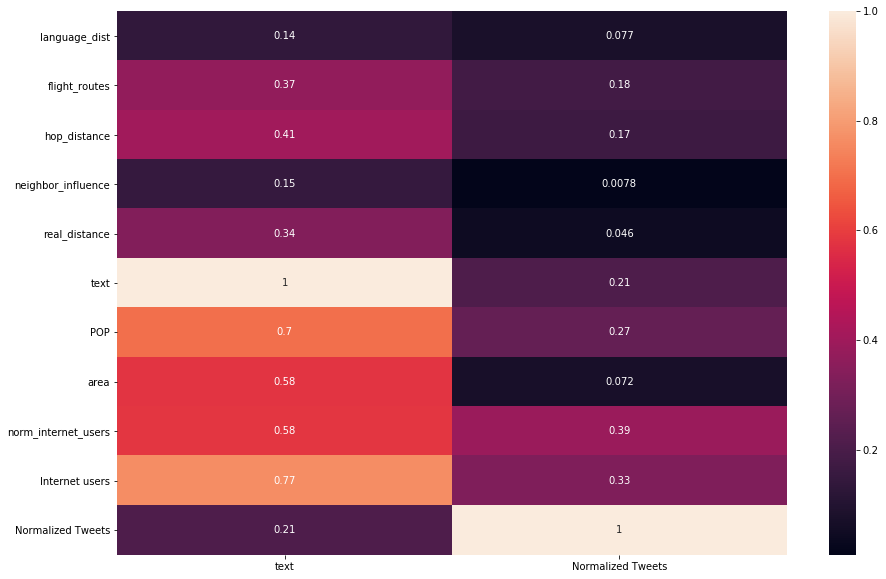

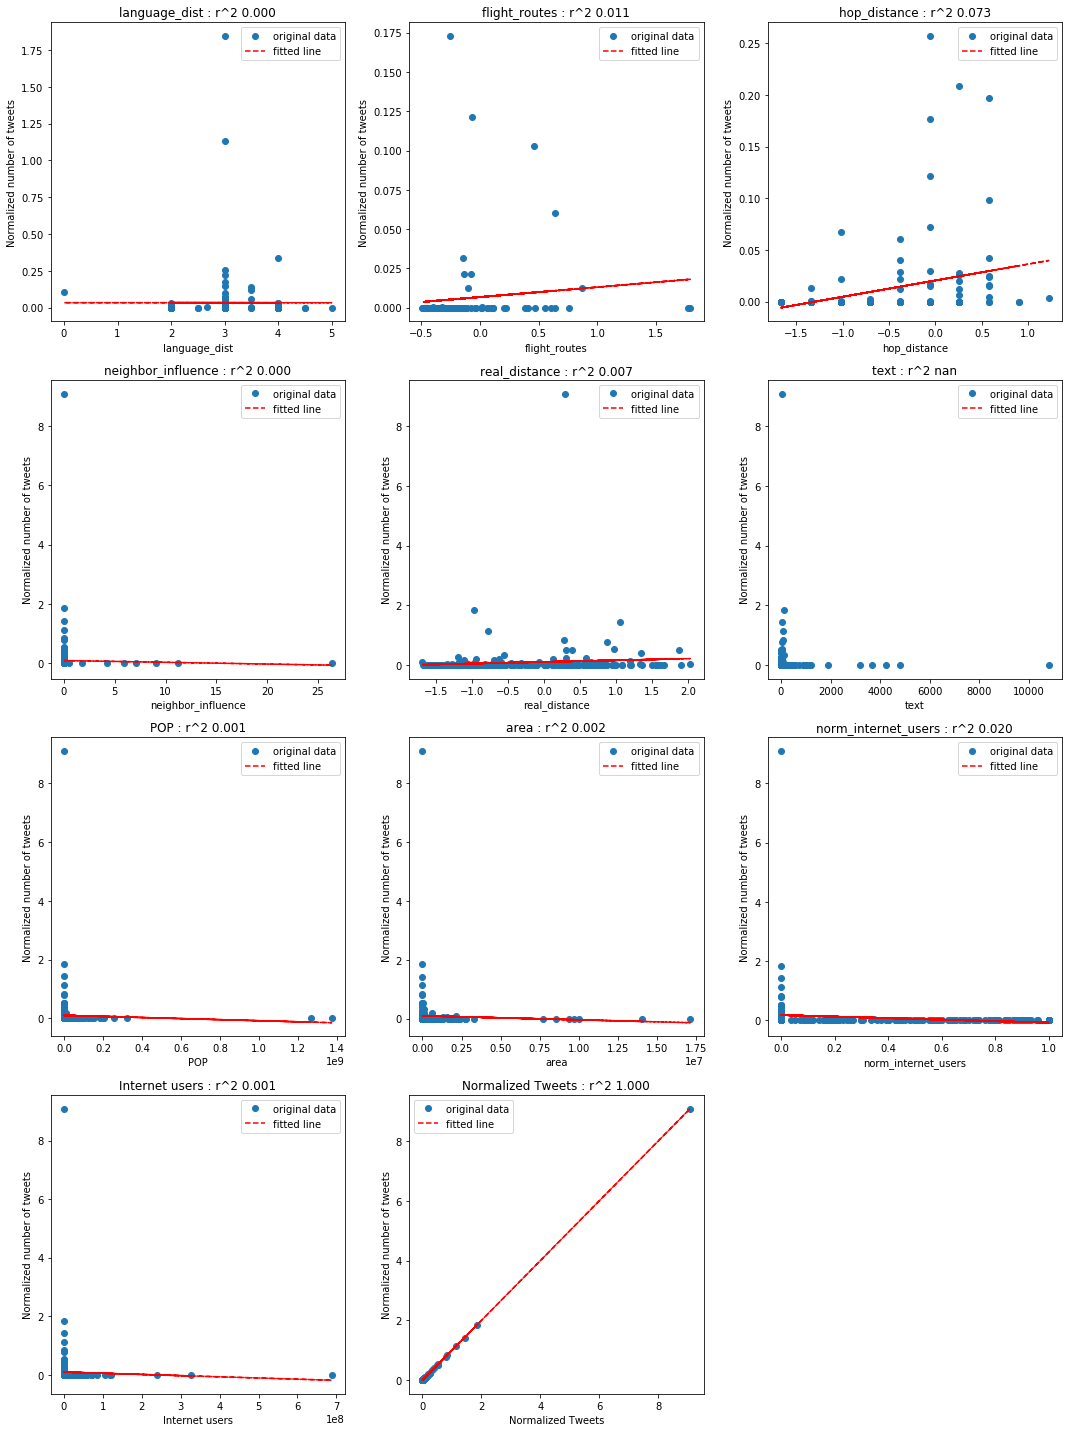

In [113]:
analyse_event("Istanbul", "TR")

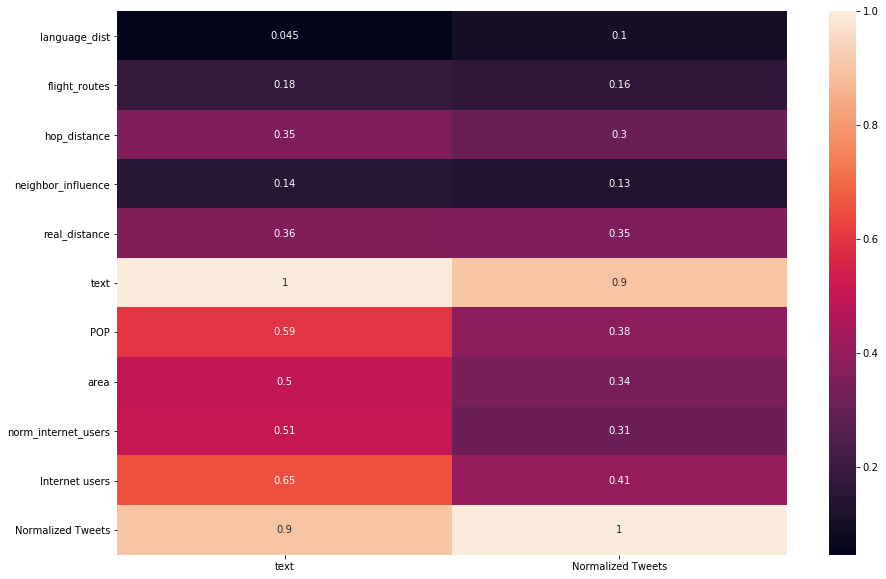

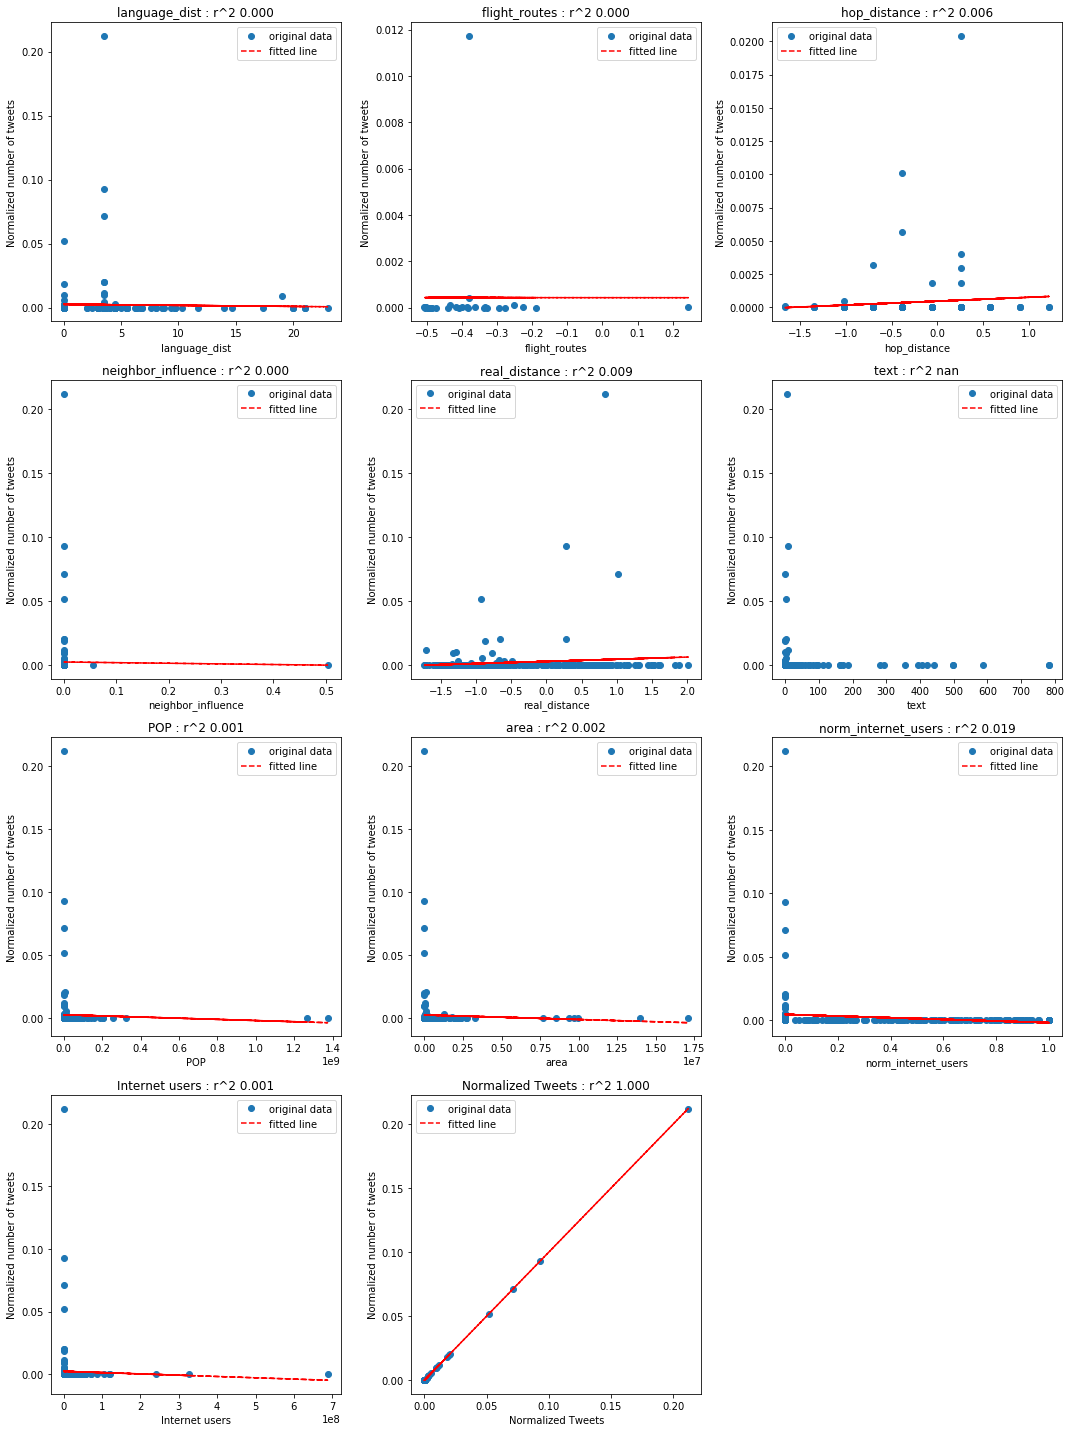

In [114]:
analyse_event("Lebanon", "LB")